# Analyzing fluorescent images with OpenCV in Python

In [1]:
%matplotlib inline
# import libraries
import cv2
import numpy as np

from matplotlib import pyplot as plt

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

In [2]:

def watershed_seg(image1, image2, thresh_min = 5, min_dist = 10):
    
    # based on http://www.pyimagesearch.com/2015/11/02/watershed-opencv/
    
    # create lists to store the intensities of light in each cell in each of the two images
    image1_intensity = []
    image2_intensity = []
    classification = []
    
    # make copies of the images
    image1 = image1.copy()
    image2 = image2.copy()
    
    # we also create a combined image to draw on
    combined = cv2.addWeighted(image1, 0.5, image2, 0.5, 0)
    
    shifted1 = cv2.bilateralFilter(image1 ,9,75,75)
    gray1 = cv2.cvtColor(shifted1, cv2.COLOR_BGR2GRAY)
    _, thresh1 = cv2.threshold(gray1, thresh_min, 255, cv2.THRESH_BINARY)
    
    shifted2 = cv2.bilateralFilter(image2 ,9,75,75)
    gray2 = cv2.cvtColor(shifted2, cv2.COLOR_BGR2GRAY)
    _, thresh2 = cv2.threshold(gray2, thresh_min, 255, cv2.THRESH_BINARY)
    
    # combine thresholding images
    thresh = thresh2 + thresh1
    
    # stuff to do the watershed segmentation
    # note that this is on the combined thresh image
    # so the contours are assumed to be cells
    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=min_dist, labels=thresh)
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    
    # each 'contour' according to the watershed seg is labeled a different number, so we loop through each
    for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
        if label == 0:
            continue

        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(gray1.shape, dtype="uint8")
        mask[labels == label] = 255
        
        ## need to: 
        ## apply the labels to the combined `thresh` image
        ## apply the contours in the mask to each greyscale image
        ## find the average intensity inside the labeled parts of each greyscale image
        ## cv2.mean(image, mask)

        # detect contours in the mask and grab the largest one
        contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(contours, key = cv2.contourArea)
        
        # if the contour is large enough, we assume it's a cell.
        # we then reference the original image and find the average color in the contour region
        # in each of the original photos 
        
        if cv2.contourArea(c) > 25:
            
            # find the average intensity of the first image in the contour
            mask = np.zeros(gray1.shape,np.uint8)
            cv2.drawContours(mask,[c],0,255,-1)
            avg1 = cv2.mean(gray1, mask = mask)[0]
            image1_intensity.append(avg1)
            
            # find the average intensity of the second image in the contour
            mask = np.zeros(gray2.shape,np.uint8)
            cv2.drawContours(mask,[c],0,255,-1)
            avg2 = cv2.mean(gray2, mask = mask)[0]
            image2_intensity.append(avg2)
            
            # classify
            if avg1 >= 15 and avg2 >= 15:
                text = "both"
            elif avg1 >= 15 and avg2 < 15:
                text = "image1"
            elif avg1 < 15 and avg2 >= 15:
                text = "image2"
            
            classification.append(text)
            
            # draw the contour on the combined image
            cv2.drawContours(combined, [c], 0, (232,79,34), 1)
            # draw a circle enclosing the object
            ((x, y), r) = cv2.minEnclosingCircle(c)
            cv2.putText(combined, "{}".format(text), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (165,205,213), 1)

    plt.figure(figsize = (20,20))
    plt.imshow(combined)
    plt.title("combined")
    plt.show()
    return combined, image1_intensity, image2_intensity, classification
    

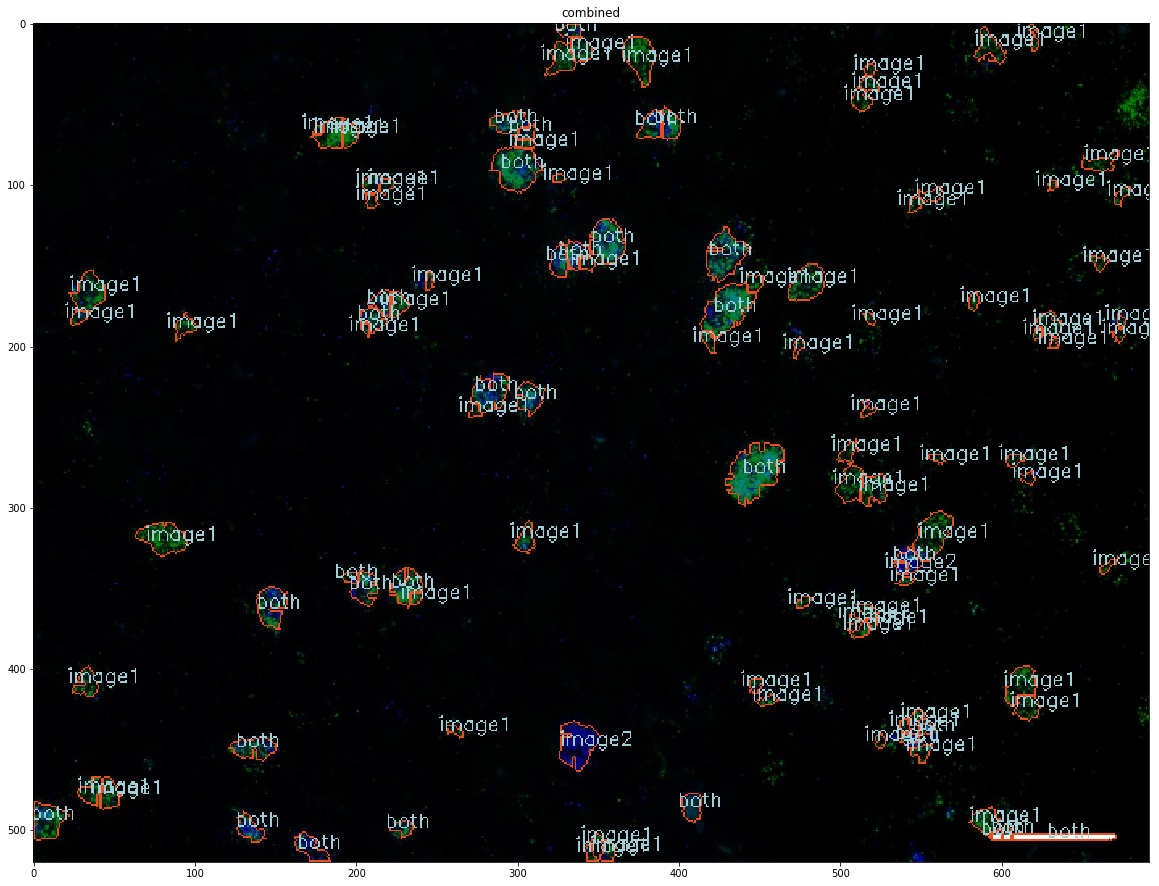

False

In [3]:
green_image = cv2.imread('test_green.jpg')
red_image = cv2.imread('test_red.jpg')

combined_image, image1_list, image2_list, labels = watershed_seg(green_image, red_image, min_dist = 5, thresh_min = 15)

cv2.imwrite('/Users/lukereding/Documents/detect_fluorescent_overlap/combined_labeled.jpg', combined_image)

In [4]:
# show histograms of image 1 and image 2 intensity expression
# (may help inform parameter choices about)

import pandas as pd
from bokeh.charts import Histogram, show, output_notebook, Scatter

df_wide = pd.DataFrame({'image_1': image1_list, 'image_2' : image2_list, 'cell' : list(range(1, len(image1_list) + 1))})

# number of cells identified
num_cells = df_wide.shape[0]

df = df_wide.melt(id_vars=['cell'])

hist = Histogram(df, values='value', color='variable',
                  title="intensity value in {} id'ed cells".format(num_cells), xlabel = "intensity", ylabel = "number", legend='top_right')
output_notebook()

show(hist)

/Users/lreding/anaconda3/envs/opencv/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Loading BokehJS ...

In [5]:
labs = pd.Series(labels)
labs.value_counts()

image1    75
both      32
image2     2
dtype: int64

In [6]:
# scatter plot


p = Scatter(df_wide, x='image_1', y='image_2', title="",
            xlabel="image 1 intensity", ylabel="image 2 intensity")

output_notebook()

show(p)

Loading BokehJS ...

------------
# using the DAPI images

- load in the images
- blob detection of DAPI
- watershed algorithm
- expand blobs
- apply mask to other pics

number of nuclei identified: 265


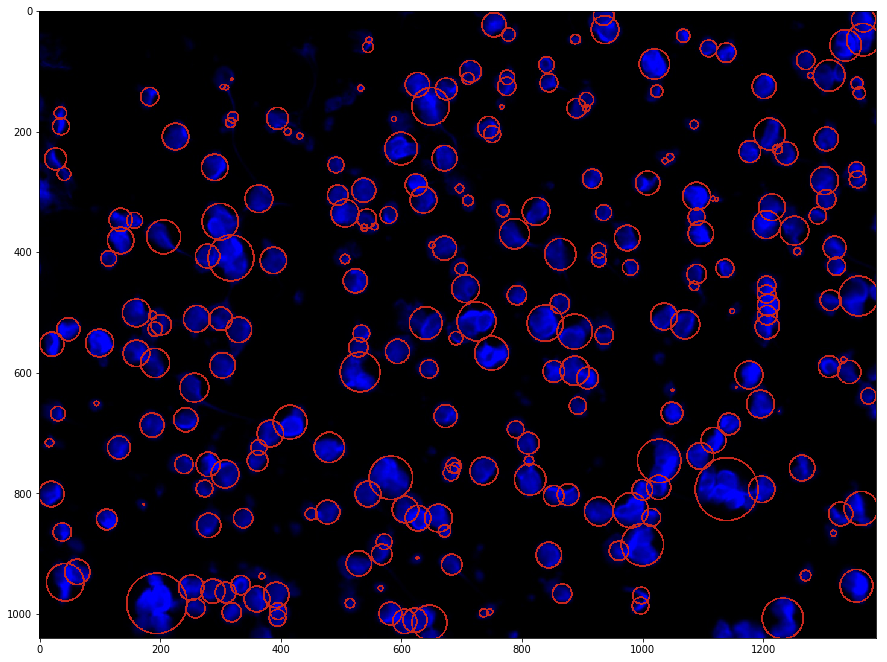

True

In [63]:
blue = cv2.imread('blue.jpg')
green = cv2.imread('green.jpg')
red = cv2.imread('red.jpg')
combined = cv2.imread('combined.jpg')

# this is the constant that gets multiplied by the radius to approximate the cell size
scaling_factor = 1

# convert red and green images to gray for later
red_gray = cv2.cvtColor(red, cv2.COLOR_BGR2GRAY)
green_gray = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)

## lists
red = []
green = []
cat = []
centers = []

# blur
blurred = cv2.bilateralFilter(blue ,9,75,75)
# convert to gray
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# threshold
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)


# watershed
D = ndimage.distance_transform_edt(thresh)

### this min_distance parameter is really important
localMax = peak_local_max(D, indices=False, min_distance= 8, labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)

print("number of nuclei identified: {}".format(len(np.unique(labels))))

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)
    
    if cv2.contourArea(c) > 25:
            
        # find the average intensity of the red stain contour
        mask = np.zeros(red_gray.shape,np.uint8)
        # get the enclosing circle of the contour
        ((x, y), r) = cv2.minEnclosingCircle(c)
        # draw the circle on an empty image to ask as a mask
        cv2.circle(mask, (int(x), int(y)), int(r*scaling_factor), 1, thickness=-1)
#         masked_red = cv2.bitwise_and(red_grey, red_grey, mask = mask)

        # get average strength of the red and green signals
        avg_red = cv2.mean(red_gray, mask = mask)[0]
        avg_green = cv2.mean(green_gray, mask = mask)[0]
        
        # add to lists
        red.append(avg_red)
        green.append(avg_green)
        centers.append((int(x), int(y)))
        
        # make into categories
        if avg_green > 20 and avg_red > 10:
            cat.append("both")
        elif avg_green <= 20 and avg_red > 10:
            cat.append("red")
        elif avg_green > 20 and avg_red <= 10:
            cat.append("green")
        else:
            cat.append("nada")

#         # find the average intensity of the red stain contour
#         mask = np.zeros(green_gray.shape,np.uint8)
        
#         # get the enclosing circle of the contour
#         ((x, y), r) = cv2.minEnclosingCircle(c)
        
#         # draw the circle on an empty image to ask as a mask
#         cv2.circle(mask, (int(x), int(y)), int(r*scaling_factor), 1, thickness=-1)
        
#         # masked_red = cv2.bitwise_and(red_grey, red_grey, mask = mask)
#         avg_red = cv2.mean(red_gray, mask = mask)[0]
#         red.append(avg_red)
        

    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(blue, (int(x), int(y)), int(r), (29, 40, 200), 2)
    cv2.putText(combined, "{}: {}".format(label, cat[-1]), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (29, 40, 200), 2)

# show the result
plt.figure(figsize=(15,15))
(B, G, R) = cv2.split(blue)
image = cv2.merge([R, G, B])
plt.imshow(image)
plt.show()

cv2.imwrite("watershed.jpg", blue)
cv2.imwrite("combined_with_measures.jpg", combined)



In [64]:
import pandas as pd
categories = pd.Series(cat)
categories.value_counts()

nada     148
green     61
red       43
both       4
dtype: int64

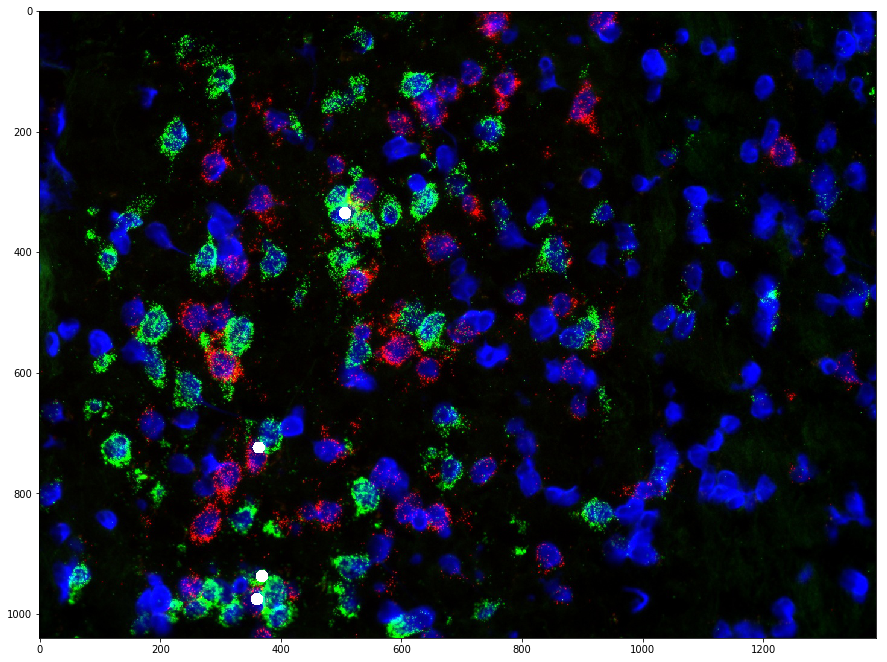

In [65]:
# put a dot on the 'both' cells

cents = [centers[i] for i, x in enumerate(cat) if x == "both"]

combined = cv2.imread('combined.jpg')

for cent in cents:
    cv2.circle(combined, cent, 10, (255,255,255), -1)

plt.figure(figsize=(15,15))
(B, G, R) = cv2.split(combined)
image = cv2.merge([R, G, B])
plt.imshow(image)
plt.show()